### **SOW-MKI49-2019-SEM1-V: NeurIPS**

# Project: Skeleton Code

In [1]:
from IPython.display import clear_output
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
import socket
from PIL import Image

class Agent:
    def __init__(self):
        pass

    def step(self, end, reward, state):
        # return 0 # nothing
        # return 1 # left
        # return 2 # right
        return   3 # random

class Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000, size = 200, timescale = 3):
        self.client     = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip         = ip
        self.port       = port
        self.size       = size
        self.timescale  = timescale

        self.client.connect((ip, port))

    def reset(self):
        self._send(1, 0)
        return self._receive()

    def step(self, action):
        self._send(2, action)
        return self._receive()

    def state2image(self, state):
        return Image.fromarray(np.array(state, "uint8").reshape(self.size, self.size, 3))

    def _receive(self):
        # Kudos to Jan for the socket.MSG_WAITALL fix!
        data   = self.client.recv(2 + 3 * self.size ** 2, socket.MSG_WAITALL)
        end    = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]

        return end, reward, state

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [4]:
class Env_number:   # Wrapper around an environment object
    
    def __init__(self, env, background=None):
        self.n3 = 3
        self.env = env
        self.env.reset()
        
        if background != None:
            self.background = background
        if background == None:
            self.background = self.automatic_background_segmentation()
            
        
    def step(self, action, get_image = False):
        
        end, reward, state = env.step(action)
        
        state = np.array(env.state2image(state))
        agents = self.agent_enhacement(state)
        #plt.imshow(agents)
        pos = self.positions(agents)
        
        if get_image:
            return end, reward, pos, agents
        
        return end, reward, pos
    
    def reset(self, get_image = False):
        end, reward, state = env.reset()
        
        state = np.array(env.state2image(state))
        agents = self.agent_enhacement(state)
        plt.imshow(agents)
        pos = self.positions(agents)
        
        if get_image:
            return end, reward, pos, agents
        
        return end, reward, pos
            
    def automatic_background_segmentation(self):
        #Get images
        
        self.env.reset()
        
        img_list = []
        for i in range(100):
            _ =  self.env.step(3)
            if i%5==0:
                img_list.append(np.array(self.env.state2image(_[-1])))
            if _[0]==1:
                break
        self.env.reset()
        
        img_list_arr = [np.array(i) for i in img_list]
        
        
    
        from itertools import product

        dim_x, dim_y, n_channels = img_list[0].shape
        canvas_baseline = np.zeros((dim_x, dim_y, n_channels))

        for x,y,c in product([i for i in range(dim_x)],[i for i in range(dim_y)],[i for i in range(n_channels)]):
            values, counts = np.unique([i[x,y][c] for i in img_list_arr ], return_counts = True)
            canvas_baseline[x,y,c] = values[np.argmax(counts)]

        return canvas_baseline.astype(int)
    
    def agent_enhacement(self, img_list):
        
        if type(img_list)!=list:
            img_list_support = []
            img_list_support.append(img_list)
            img_list = img_list_support
            
        modified_imgs = []
        for i in img_list:
            
            
            base = np.abs(self.background - np.array(i))
            #plt.imshow(base)
            #plt.show()

            gray = cv2.cvtColor(np.uint8(base), cv2.COLOR_BGR2GRAY)
            #plt.imshow(gray)
            #plt.show()

            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            res = cv2.bitwise_and(np.uint8(i),np.uint8(i),mask = np.uint8(thresh))
            #plt.imshow(res)
            #plt.show()

            modified_imgs.append(res)    
            #plt.show()
        if len(modified_imgs)==1:
            return modified_imgs[0]
        
        return modified_imgs
    
    
    def positions(self, image):

        image_original = np.copy(image)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)

        kernel = np.ones((5,5), np.uint8)
        image = cv2.dilate(image, kernel, iterations = 3)
        image = cv2.erode(image, kernel, iterations = 3)


        a, contours, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

        pos = []
        if len(contours)>1:
            dict_red_centers = {}
            for contour in contours:
                (x,y,w,h) = cv2.boundingRect(contour)

                #plt.imshow(image_original[y:y+h,x:x+w,0])
                #plt.show()

                red_value = np.where(image_original[y:y+h,x:x+w,0]!=0)

                agent_crop = image_original[y:y+h,x:x+w,0]

                red_sum = 0
                for x_i, y_i in zip(red_value[0], red_value[1]):
                    red_sum += int(agent_crop[x_i, y_i])

                dict_red_centers[red_sum]=(int(x+w/2), int(y+h/2))

            for agent in sorted(dict_red_centers.keys())[::-1]: #red first
                pos.append(dict_red_centers[agent])


        if len(contours)==1:

            image = image_original

            a = np.where(image[:,:,0]!=[0])
            values = []
            for i in zip(a[0], a[1]):
                values.append(image[i[0],i[1],0])


            _, img = cv2.threshold(image[:,:,0], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

            M = cv2.moments(img)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            red_agent = (cX, cY)

            #############


            a = np.where(image[:,:,2]!=[0])
            values = []
            for i in zip(a[0], a[1]):
                values.append(image[i[0],i[1],2])


            _, img = cv2.threshold(image[:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

            M = cv2.moments(img)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            blue_agent = (cX, cY)

            pos = [red_agent, blue_agent]

        return pos

In [5]:
env = Environment()

In [6]:
env_n = Env_number(env)

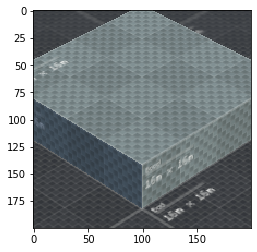

In [7]:
plt.imshow(env_n.background)

(0, 0, [(43, 51), (155, 53)])
(0, 0, [(44, 50), (154, 53)])
(0, 0, [(47, 51), (152, 54)])
(0, 0, [(49, 51), (149, 54)])
(0, 0, [(52, 52), (147, 55)])
(0, 0, [(55, 51), (146, 55)])
(0, 0, [(57, 52), (145, 54)])
(0, 0, [(59, 51), (141, 54)])
(0, 0, [(60, 51), (140, 54)])
(0, 0, [(62, 51), (137, 53)])
(0, 0, [(65, 51), (135, 53)])
(0, 0, [(66, 52), (134, 53)])
(0, 0, [(68, 52), (132, 53)])
(0, 0, [(71, 52), (130, 53)])
(0, 0, [(73, 52), (127, 53)])
(0, 0, [(75, 52), (126, 53)])
(0, 0, [(77, 52), (124, 52)])
(0, 0, [(79, 52), (123, 52)])
(0, 0, [(81, 52), (120, 51)])
(0, 0, [(82, 52), (119, 50)])
(0, 0, [(84, 51), (117, 50)])
(0, 0, [(99, 48), (102, 48)])
(0, 0, [(91, 48), (107, 47)])
(0, 0, [(99, 49), (102, 49)])
(0, 0, [(100, 48), (104, 48)])
(0, 0, [(100, 49), (103, 49)])
(0, 0, [(99, 49), (109, 48)])
(0, 0, [(99, 50), (105, 49)])
(0, 0, [(102, 51), (105, 50)])
(0, 0, [(99, 50), (110, 49)])
(0, 0, [(101, 51), (105, 50)])
(0, 0, [(100, 50), (106, 50)])
(0, 0, [(101, 50), (105, 50)])
(0, 

KeyboardInterrupt: 

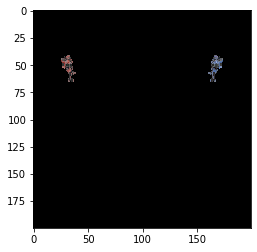

In [12]:
for i in range(10000):
    r = env_n.step(0)
    print(r)
    if r[0]==1:
        env_n.reset()

In [2]:
img_list = []

In [3]:
import time

In [4]:
def loop():
    
    for i in range(300):
        rec = env.step(3)
        print(rec[:2])
        
        if not i%10:
            clear_output()
        
        if rec[0]!=0:
            if rec[0] == 1:
                env.reset()
                loop()
            if rec[0]!=1:
                print(rec[0])
                time.sleep(10000)
    return 0

In [7]:
#loop()

In [8]:
img_list = []
for i in range(100):
    _ =  env.step(3)
    if i%5==0:
        img_list.append(env.state2image(_[-1]))
    if _[0]==1:
        break

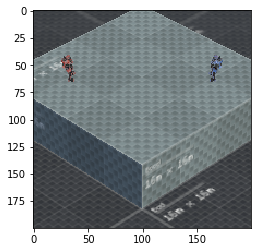

In [9]:
plt.imshow(img_list[0])

In [10]:
env.reset();

In [55]:
baseline = cv2.imread('/Users/Jose/Downloads/baseline.png')

In [12]:
img_list_arr = []

for i in img_list:
    img_list_arr.append(np.array(i))

In [15]:
size = img_list_arr[0].shape
print(size)

(768, 768, 3)


In [16]:
canvas_baseline = np.zeros(size)

In [17]:
canvas_baseline[0,0]=[1,1,1]

In [18]:
%%time
for x,y,c in itertools.product([i for i in range(768)],[i for i in range(768)],[i for i in range(3)]):
    values, counts = np.unique([i[x,y][c] for i in img_list_arr ], return_counts = True)
    canvas_baseline[x,y,c] = values[np.argmax(counts)]

CPU times: user 55 s, sys: 705 ms, total: 55.7 s
Wall time: 56.7 s


In [313]:
np.random.permutation(len(img_list_arr))[:4]

array([13,  4, 12, 19])

In [11]:
img_list_arr = []
for i in map(np.array,img_list):
    img_list_arr.append(i)

In [12]:
img_list_arr[0].shape

(200, 200, 3)

In [13]:
def automatic_background_segmentation(list_imgs):
    
    from itertools import product
    
    dim_x, dim_y, n_channels = list_imgs[0].shape
    
    canvas_baseline = np.zeros((dim_x, dim_y, n_channels))
    
    for x,y,c in product([i for i in range(dim_x)],[i for i in range(dim_y)],[i for i in range(n_channels)]):
        values, counts = np.unique([i[x,y][c] for i in img_list_arr ], return_counts = True)
        canvas_baseline[x,y,c] = values[np.argmax(counts)]
    
    return canvas_baseline.astype(int)

In [14]:
plt.figure(figsize=(10,10))
random_list = [img_list_arr[i] for i in np.random.permutation(len(img_list_arr))[:4]]
background = automatic_background_segmentation(list_imgs=random_list)

<Figure size 720x720 with 0 Axes>

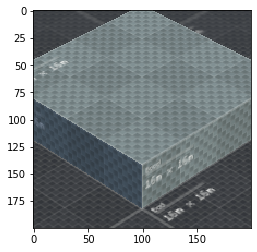

In [15]:
plt.imshow(background)

In [16]:
background.shape

(200, 200, 3)

In [27]:
baseline = background

def agent_enhacement(img_list, baseline):
    modified_imgs = []
    for i in img_list:

        base = np.abs(baseline - np.array(i))
        #plt.imshow(base)
        #plt.show()

        gray = cv2.cvtColor(np.uint8(base), cv2.COLOR_BGR2GRAY)
        #plt.imshow(gray)
        #plt.show()

        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        res = cv2.bitwise_and(np.uint8(i),np.uint8(i),mask = np.uint8(thresh))
        #plt.imshow(res)
        #plt.show()

        modified_imgs.append(res)    
        #plt.show()
    return modified_imgs

In [35]:
modified_imgs =agent_enhacement(img_list, baseline)

In [19]:
plt.figure(figsize=(10,10))

image = cv2.cvtColor(modified_imgs[-8], cv2.COLOR_RGB2GRAY)
_, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
 
kernel = np.ones((5,5), np.uint8)
image = cv2.dilate(image, kernel, iterations = 3)
image = cv2.erode(image, kernel, iterations = 3)


a, b, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)


if len(b)==1:
        pos = []
    for n, contour in enumerate(b):
        print(n)
        (x,y,w,h) = cv2.boundingRect(contour)
        pos.append(((int(x+w/2), int(y+h/2))))
if len(b)>1:
    None

plt.imshow(image)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [36]:
def positions(image):
    
    image_original = np.copy(image)
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)

    kernel = np.ones((5,5), np.uint8)
    image = cv2.dilate(image, kernel, iterations = 3)
    image = cv2.erode(image, kernel, iterations = 3)


    a, contours, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    pos = []
    if len(contours)>1:
        dict_red_centers = {}
        for contour in contours:
            (x,y,w,h) = cv2.boundingRect(contour)

            #plt.imshow(image_original[y:y+h,x:x+w,0])
            #plt.show()

            red_value = np.where(image_original[y:y+h,x:x+w,0]!=0)

            agent_crop = image_original[y:y+h,x:x+w,0]

            red_sum = 0
            for x_i, y_i in zip(red_value[0], red_value[1]):
                red_sum += int(agent_crop[x_i, y_i])

            dict_red_centers[red_sum]=(int(x+w/2), int(y+h/2))

        for agent in sorted(dict_red_centers.keys())[::-1]: #red first
            pos.append(dict_red_centers[agent])
            
            
    if len(contours)==1:
        
        image = image_original
        
        a = np.where(image[:,:,0]!=[0])
        values = []
        for i in zip(a[0], a[1]):
            values.append(image[i[0],i[1],0])
        
        
        _, img = cv2.threshold(image[:,:,0], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

        M = cv2.moments(img)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        red_agent = (cX, cY)

        #############
        
        
        a = np.where(image[:,:,2]!=[0])
        values = []
        for i in zip(a[0], a[1]):
            values.append(image[i[0],i[1],2])
            

        _, img = cv2.threshold(image[:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

        M = cv2.moments(img)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        blue_agent = (cX, cY)
        
        pos = [red_agent, blue_agent]
        
    return pos


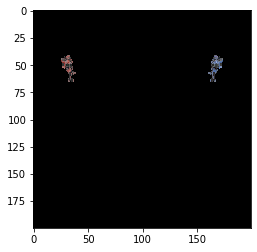

In [37]:
plt.imshow(modified_imgs[0])

In [38]:
modified_imgs[0].shape

(200, 200, 3)

[(32, 53), (167, 53)]


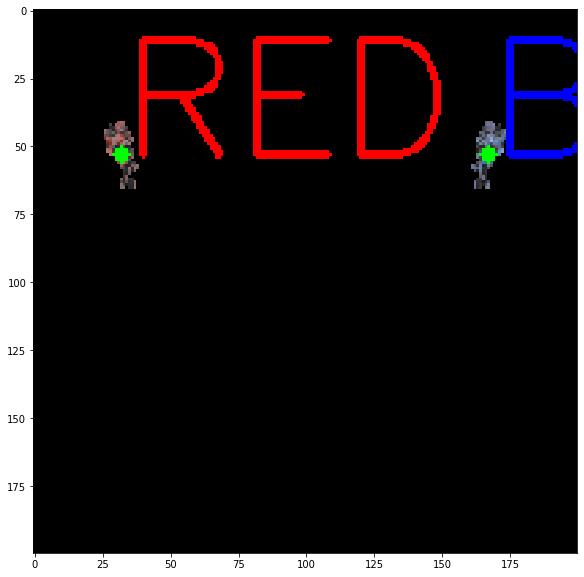

[(43, 51), (157, 51)]


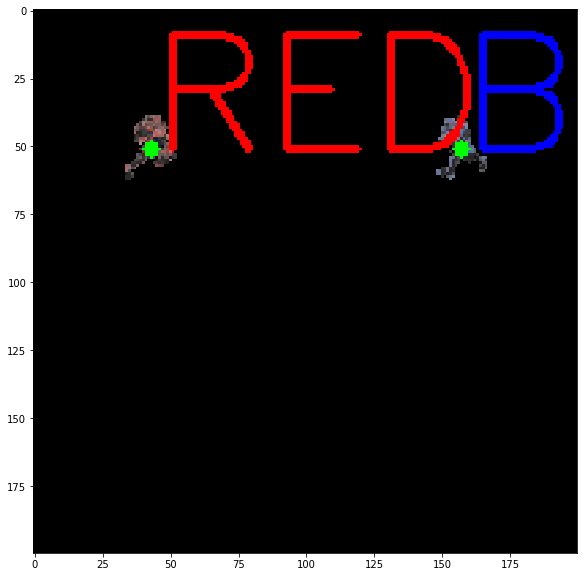

[(53, 49), (146, 51)]


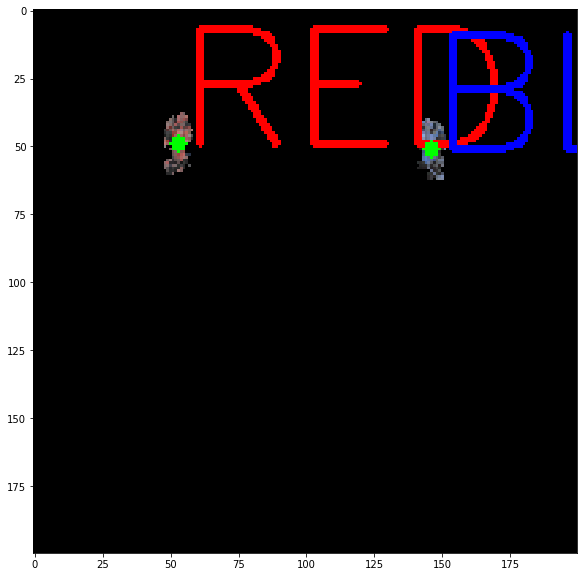

[(64, 48), (135, 49)]


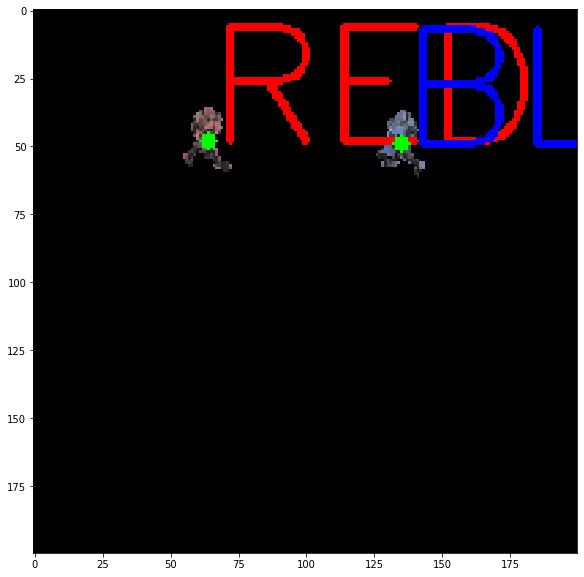

[(73, 48), (126, 49)]


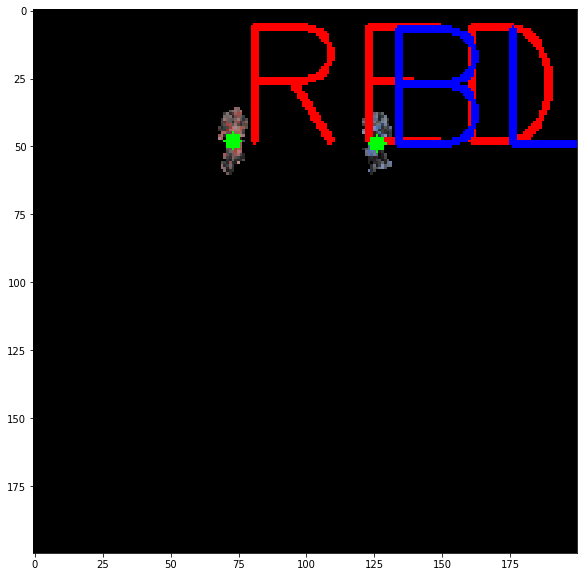

[(83, 47), (115, 48)]


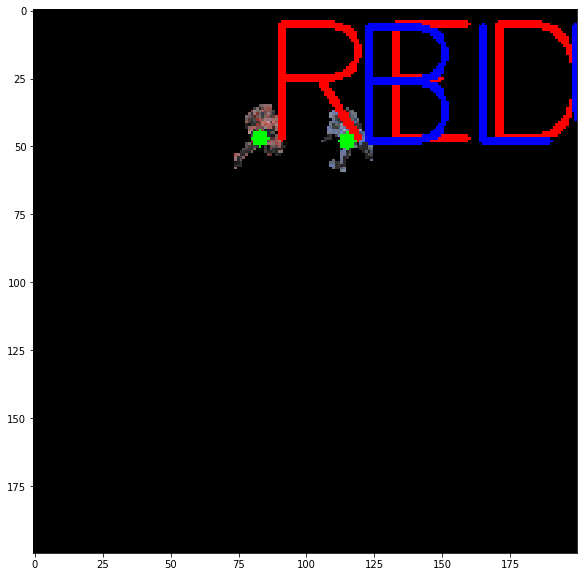

[(100, 47), (103, 47)]


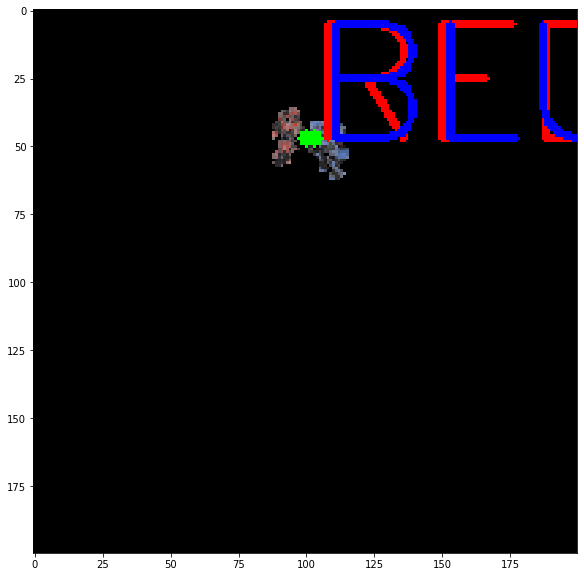

[(107, 47), (110, 50)]


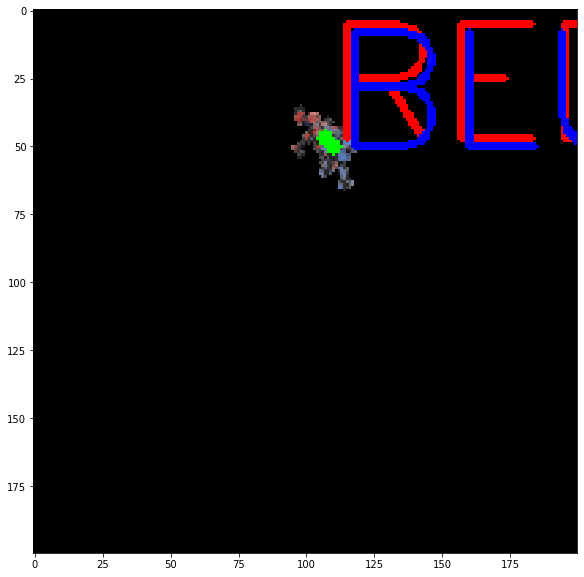

[(114, 51), (116, 58)]


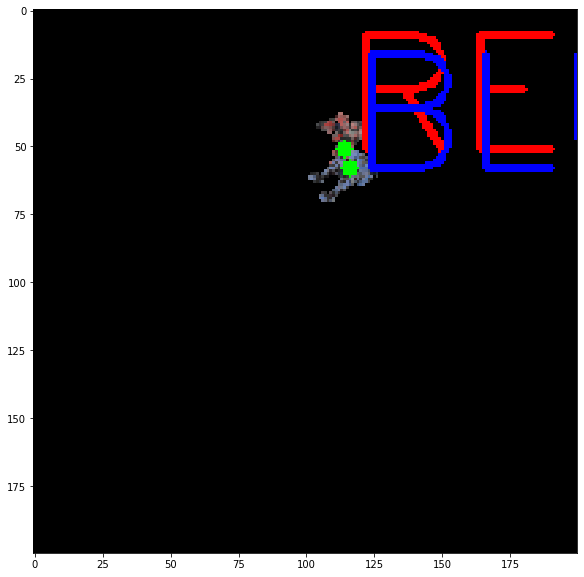

[(123, 48), (118, 62)]


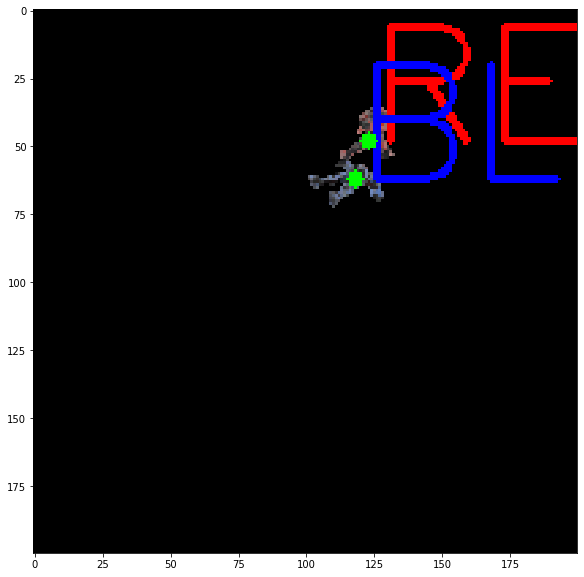

[(126, 50), (115, 58)]


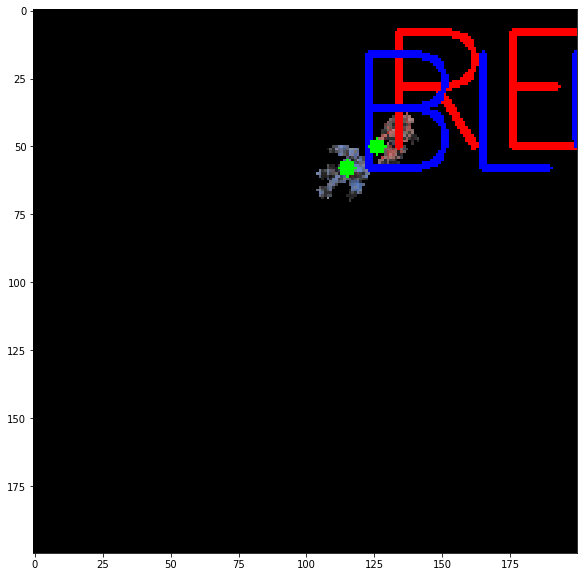

[(144, 52), (106, 56)]


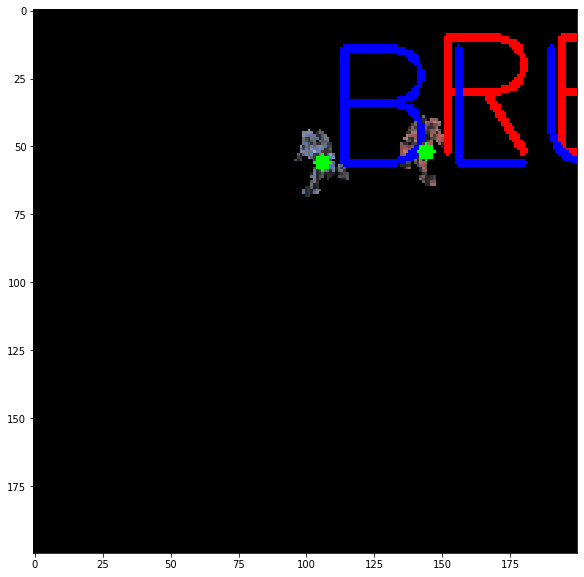

[(152, 55), (95, 59)]


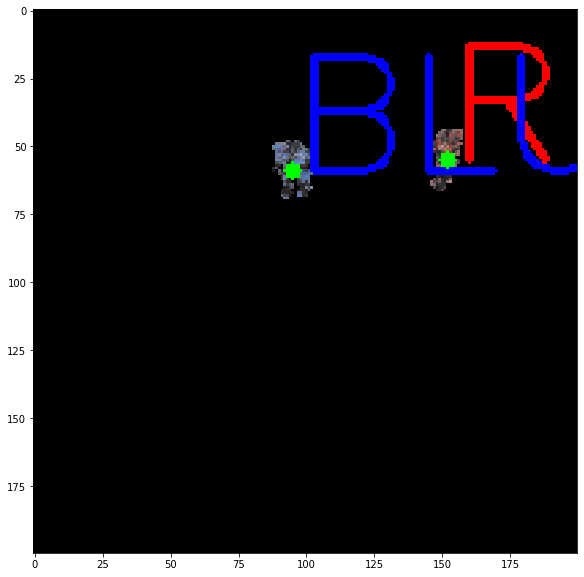

[(160, 55), (93, 66)]


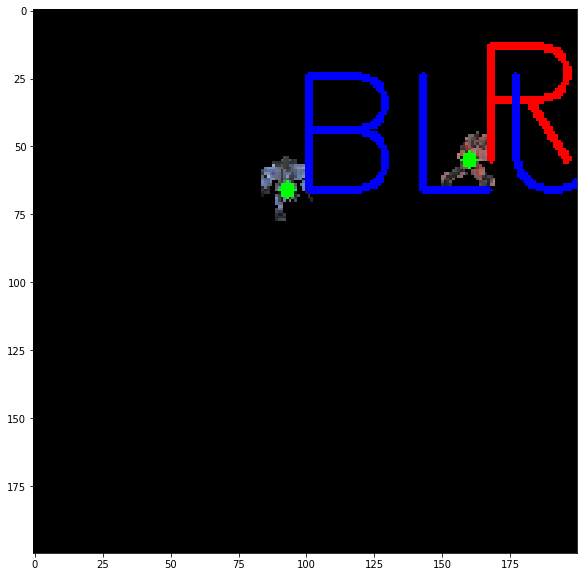

[(172, 60), (97, 69)]


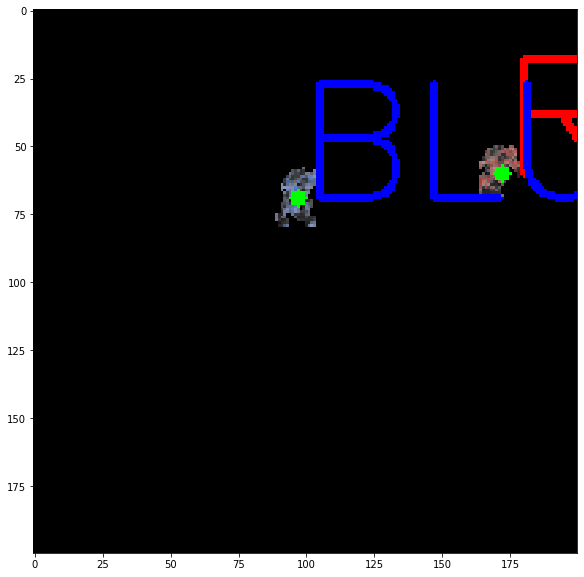

[(178, 66), (105, 71)]


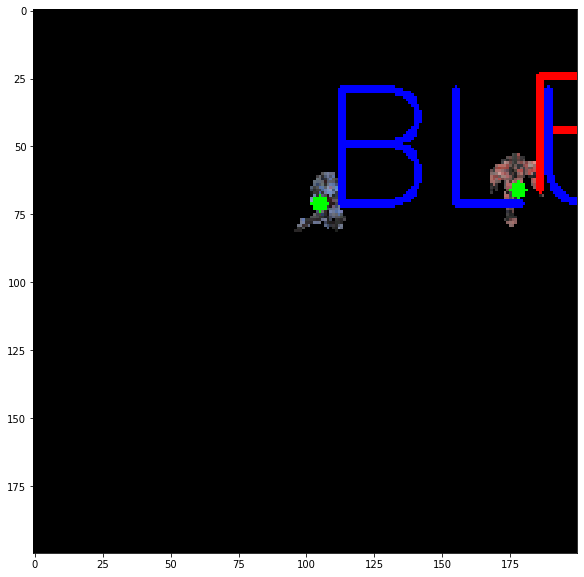

[(182, 70), (116, 69)]


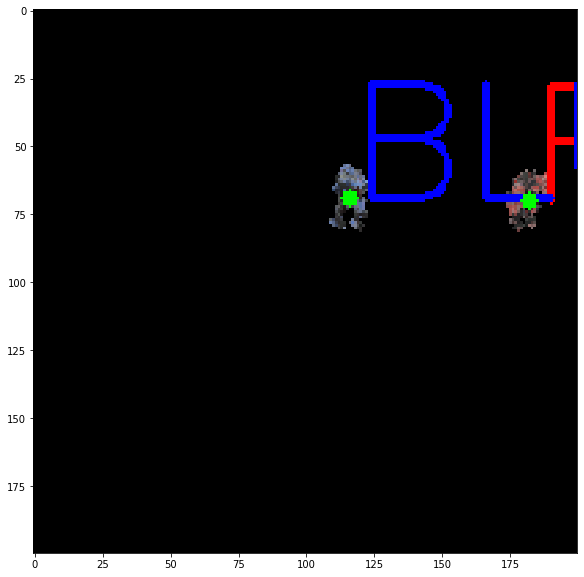

[(188, 74), (125, 67)]


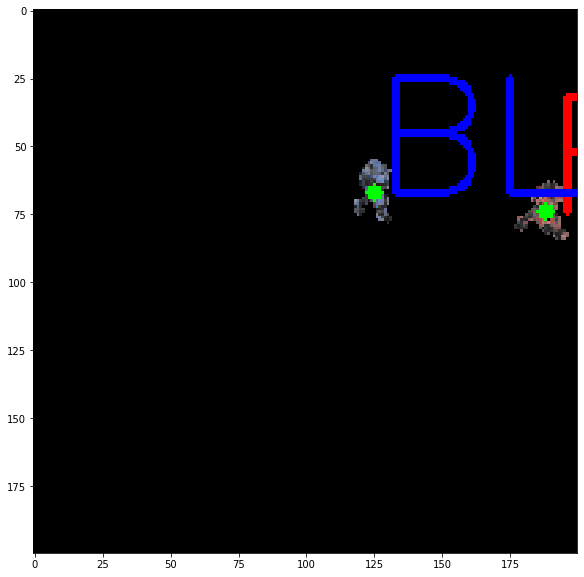

[(136, 66), (194, 79)]


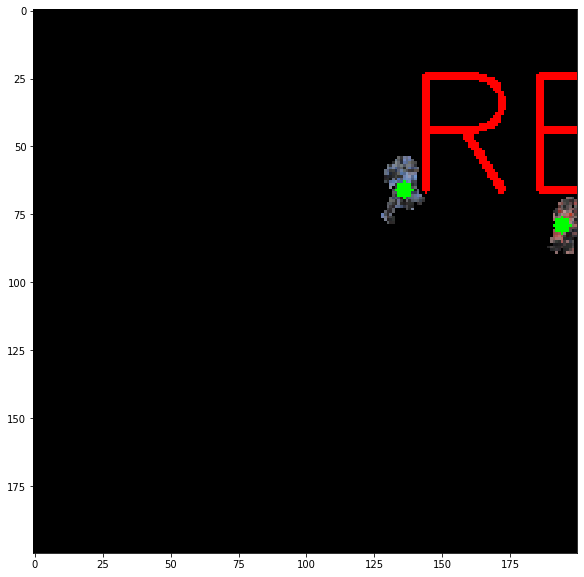

In [41]:
for i in modified_imgs:
    print(positions(i))
    post = positions(i)
    copy = np.copy(i)
    plt.figure(figsize=(10,10))
    cv2.putText(copy, 'RED', org = post[0], color = (255,0,0), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, thickness = 2)
    cv2.putText(copy, 'BLUE', org = post[1], color = (0,0,255), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 2, thickness = 2)
    cv2.circle(copy, post[0], radius = 3, color = (0,255,0), thickness = -1)
    cv2.circle(copy, post[1], radius = 3, color = (0,255,0), thickness = -1)
    plt.imshow(copy)
    plt.show()

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [42]:
env = Environment()
nb_actions = 3

In [50]:
type([a])==list

True

In [3]:
class Env_number:   # Wrapper around an environment object
    
    def __init__(self, env, background=None):
        
        self.env = env
        self.env.reset()
        
        if background != None:
            self.background = background
        if background == None:
            self.backgound = self.automatic_background_segmentation()
        
    def step(self, action, get_image = False):
        end, reward, state = env.step(action)
        
        state = np.array(env.state2image(state))
        agents = self.agent_enhacement(state)
        plt.imshow(agents)
        pos = self.positions(agents)
        
        if get_image:
            return end, reward, pos, agents
        
        return end, reward, pos
    
    def reset(self, get_image = False):
        end, reward, state = env.reset()
        
        state = np.array(env.state2image(state))
        agents = self.agent_enhacement(state)
        plt.imshow(agents)
        pos = self.positions(agents)
        
        if get_image:
            return end, reward, pos, agents
        
        return end, reward, pos
            
    def automatic_background_segmentation(self):
        #Get images
        
        self.env.reset()
        
        img_list = []
        for i in range(100):
            _ =  self.env.step(3)
            if i%5==0:
                img_list.append(np.array(self.env.state2image(_[-1])))
            if _[0]==1:
                break
        self.env.reset()
        
        img_list_arr = [np.array(i) for i in img_list]
        
        
    
        from itertools import product

        dim_x, dim_y, n_channels = img_list[0].shape
        canvas_baseline = np.zeros((dim_x, dim_y, n_channels))

        for x,y,c in product([i for i in range(dim_x)],[i for i in range(dim_y)],[i for i in range(n_channels)]):
            values, counts = np.unique([i[x,y][c] for i in img_list_arr ], return_counts = True)
            canvas_baseline[x,y,c] = values[np.argmax(counts)]

        return canvas_baseline.astype(int)
    
    def agent_enhacement(self, img_list):
        
        print(img_list.shape)
        
        if type(img_list)!=list:
            img_list_support = []
            img_list_support.append(img_list)
            img_list = img_list_support
            
        modified_imgs = []
        for i in img_list:
            
            print(i.shape)
            
            base = np.abs(baseline - np.array(i))
            #plt.imshow(base)
            #plt.show()

            gray = cv2.cvtColor(np.uint8(base), cv2.COLOR_BGR2GRAY)
            #plt.imshow(gray)
            #plt.show()

            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            res = cv2.bitwise_and(np.uint8(i),np.uint8(i),mask = np.uint8(thresh))
            #plt.imshow(res)
            #plt.show()

            modified_imgs.append(res)    
            #plt.show()
        if len(modified_imgs)==1:
            return modified_imgs[0]
        
        return modified_imgs
    
    
    def positions(self, image):

        image_original = np.copy(image)

        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)

        kernel = np.ones((5,5), np.uint8)
        image = cv2.dilate(image, kernel, iterations = 3)
        image = cv2.erode(image, kernel, iterations = 3)


        a, contours, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

        pos = []
        if len(contours)>1:
            dict_red_centers = {}
            for contour in contours:
                (x,y,w,h) = cv2.boundingRect(contour)

                #plt.imshow(image_original[y:y+h,x:x+w,0])
                #plt.show()

                red_value = np.where(image_original[y:y+h,x:x+w,0]!=0)

                agent_crop = image_original[y:y+h,x:x+w,0]

                red_sum = 0
                for x_i, y_i in zip(red_value[0], red_value[1]):
                    red_sum += int(agent_crop[x_i, y_i])

                dict_red_centers[red_sum]=(int(x+w/2), int(y+h/2))

            for agent in sorted(dict_red_centers.keys())[::-1]: #red first
                pos.append(dict_red_centers[agent])


        if len(contours)==1:

            image = image_original

            a = np.where(image[:,:,0]!=[0])
            values = []
            for i in zip(a[0], a[1]):
                values.append(image[i[0],i[1],0])


            _, img = cv2.threshold(image[:,:,0], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

            M = cv2.moments(img)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            red_agent = (cX, cY)

            #############


            a = np.where(image[:,:,2]!=[0])
            values = []
            for i in zip(a[0], a[1]):
                values.append(image[i[0],i[1],2])


            _, img = cv2.threshold(image[:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

            M = cv2.moments(img)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            blue_agent = (cX, cY)

            pos = [red_agent, blue_agent]

        return pos

In [4]:
env = Environment()

In [5]:
env_n = Env_number(env)

KeyboardInterrupt: 

In [ ]:
plt.imshow(env_n.backgound)

(200, 200, 3)
(200, 200, 3)


(0, 0, [(35, 53), (165, 53)])

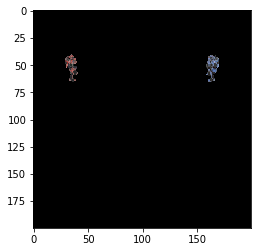

In [200]:
env_n.step(0)

(200, 200, 3)
(200, 200, 3)


(0, 0, [(32, 53), (167, 53)])

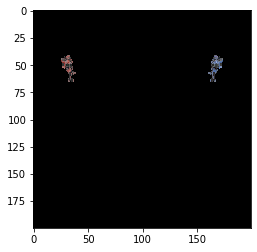

In [199]:
env_n.reset()

In [1]:

class Agent:
    def __init__(self):
        pass

    def step(self, end, reward, state):
        # return 0 # nothing
        # return 1 # left
        # return 2 # right
        return   3 # random

class Environment:
    def __init__(self, ip = "127.0.0.1", port = 13000, size = 200, timescale = 3):
        self.client     = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip         = ip
        self.port       = port
        self.size       = size
        self.timescale  = timescale

        self.client.connect((ip, port))

    def reset(self):
        self._send(1, 0)
        return self._receive()

    def step(self, action):
        self._send(2, action)
        return self._receive()

    def state2image(self, state):
        return Image.fromarray(np.array(state, "uint8").reshape(self.size, self.size, 3))

    def _receive(self):
        # Kudos to Jan for the socket.MSG_WAITALL fix!
        data   = self.client.recv(2 + 3 * self.size ** 2, socket.MSG_WAITALL)
        end    = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]

        return end, reward, state

    def _send(self, action, command):
        self.client.send(bytes([action, command]))

In [46]:
model = Sequential()
model.add(Flatten(input_shape=(1,4)))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
dqn.fit(env, nb_steps=5000, visualize=True, verbose=2)

TypeError: len is not well defined for symbolic Tensors. (activation_2/Identity:0) Please call `x.shape` rather than `len(x)` for shape information.

In [ ]:
# Image processing insides

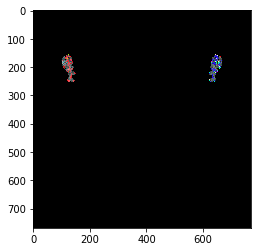

In [776]:
plt.imshow(modified_imgs[0])

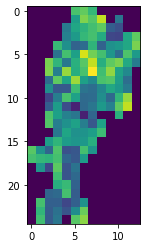

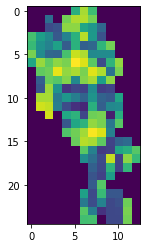

18751
14393
[(32, 53), (167, 53)]


In [40]:
image = np.copy(modified_imgs[0])
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)

kernel = np.ones((5,5), np.uint8)
image = cv2.dilate(image, kernel, iterations = 3)
image = cv2.erode(image, kernel, iterations = 3)


a, contours, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

pos = []
if len(contours)>1:
    dict_red_centers = {}
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        
        plt.imshow(modified_imgs[0][y:y+h,x:x+w,0])
        plt.show()
        
        red_value = np.where(modified_imgs[0][y:y+h,x:x+w,0]!=0)
        
        agent_crop = modified_imgs[0][y:y+h,x:x+w,0]
        
        red_sum = 0
        for x_i, y_i in zip(red_value[0], red_value[1]):
            red_sum += int(agent_crop[x_i, y_i])
        
        dict_red_centers[red_sum]=(int(x+w/2), int(y+h/2))
        
    for agent in sorted(dict_red_centers.keys())[::-1]: #red first
        print(agent)
        pos.append(dict_red_centers[agent])
            
print(pos)

In [798]:
sorted(dict_red_centers.keys())[::-1]

[337196, 190722]

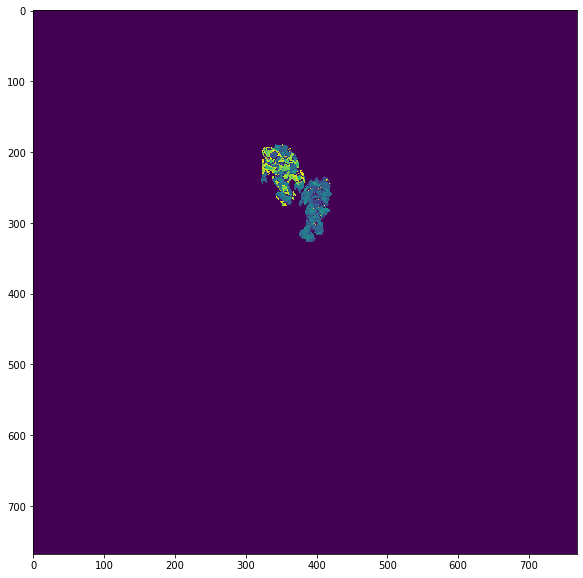

([array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([768.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
  arra

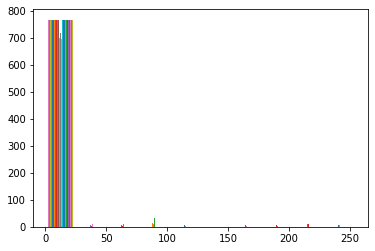

In [165]:
image = np.copy(modified_imgs[0])
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)

kernel = np.ones((5,5), np.uint8)
image = cv2.dilate(image, kernel, iterations = 3)
image = cv2.erode(image, kernel, iterations = 3)


a, contours, c = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

pos = []
if len(contours)>1:
    dict_red_centers = {}
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        
        plt.imshow(modified_imgs[0][y:y+h,x:x+w,0])
        plt.show()
        
        red_value = np.where(modified_imgs[0][y:y+h,x:x+w,0]!=0)
        
        agent_crop = modified_imgs[0][y:y+h,x:x+w,0]
        
        red_sum = 0
        for x,y in zip(red_value[0], red_value[1]):
            red_sum += agent_crop[x,y])
        
        dict_red_centers[red_value]=(int(x+w/2), int(y+h/2))
        
        #pos.append(((int(x+w/2), int(y+h/2))))
print(dict_red_centers)

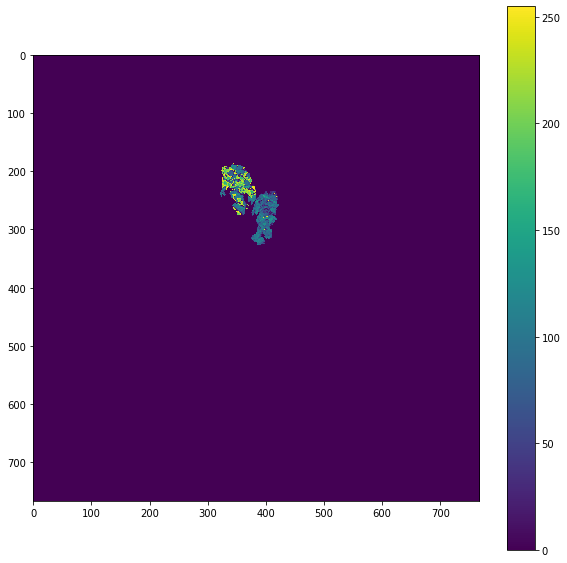

In [635]:
plt.figure(figsize=(10,10))
plt.imshow(modified_imgs[-8][:,:,2])
plt.colorbar()

a = np.where(modified_imgs[-8][:,:,2]!=[0])

In [644]:
a = np.where(modified_imgs[-8][:,:,2]!=[0])
values = []
for i in zip(a[0], a[1]):
    values.append(image[i[0],i[1],2])

In [657]:
print(len(values))
sorted(values)
values[int(len(values)/1.1)]

6076


103

361 238


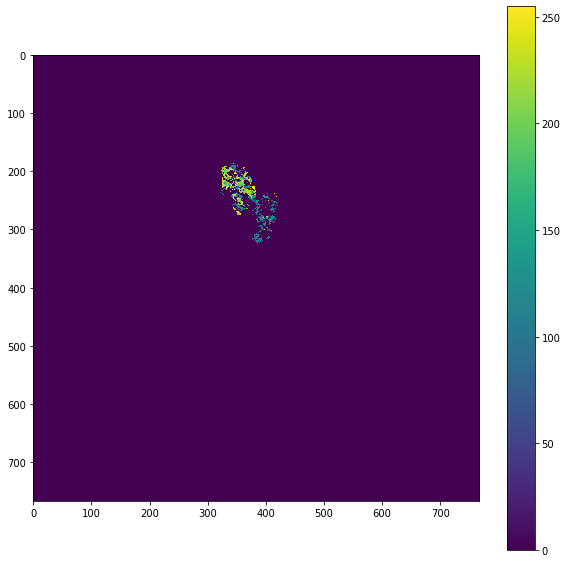

In [734]:
plt.figure(figsize=(10,10))
_, img = cv2.threshold(modified_imgs[-8][:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)


M = cv2.moments(img)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print(cX,cY)

plt.imshow(img)
plt.colorbar()
plt.show()

In [737]:
np.where(img!=0)

(array([188, 189, 190, ..., 325, 326, 327]),
 array([344, 352, 342, ..., 386, 385, 385]))

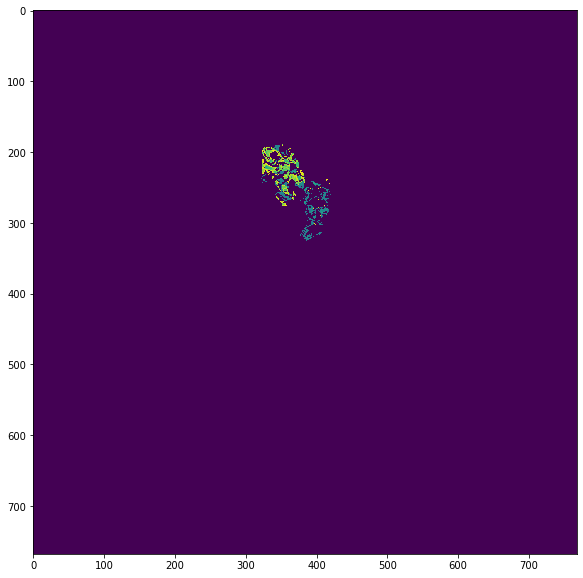

In [735]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [714]:
def average_value(img):
    color = np.where(img != 0)
    print(len(color[0]))

In [715]:
average_value(img)

3280


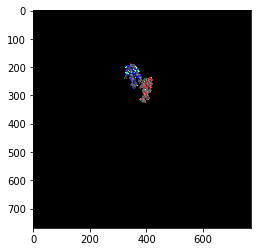

In [746]:
plt.imshow(modified_imgs[-8])

361 238


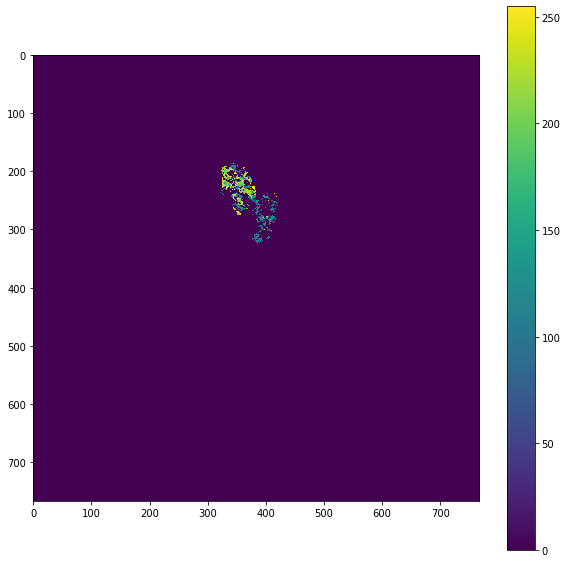

In [745]:
plt.figure(figsize=(10,10))
_, img = cv2.threshold(modified_imgs[-8][:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)


M = cv2.moments(img)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print(cX,cY)

non_zero = np.where(img!=0)


red_agent = (cX, cY)

plt.imshow(img)
plt.colorbar()
plt.show()

391 267


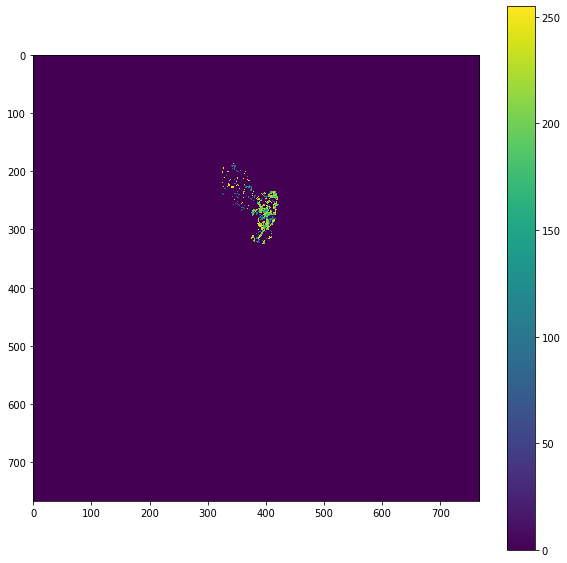

In [744]:
def single_blob(img):
    _, img = cv2.threshold(img[:,:,0], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

    M = cv2.moments(img)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    red_agent = (cX, cY)

    #############

    _, img = cv2.threshold(img[:,:,2], values[-int(len(values)/10)], 255, cv2.THRESH_TOZERO)

    M = cv2.moments(img)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    blue_agent = (cX, cY)


    return [red_agent, blue_agent]

In [741]:
plt.figure(figsize=(10,10))

mf = np.copy(modified_imgs[-8])


ret3,th3 = cv.threshold(mf,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)


M = cv2.moments(modified_imgs[-8][:,:,0])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print(cX, cY)
cv2.circle(mf, (cX, cY), 4, (0,255,0), cv2.FILLED)

M = cv2.moments(modified_imgs[-8][:,:,2])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
print(cX, cY)
cv2.circle(mf, (cX, cY), 4, (0,255,0), cv2.FILLED)

plt.imshow(mf)

NameError: name 'cv' is not defined

<Figure size 720x720 with 0 Axes>

In [142]:
for i in range(a[0].shape):
    modified_imgs[a[0][i],a[1][1]]

(6076,)

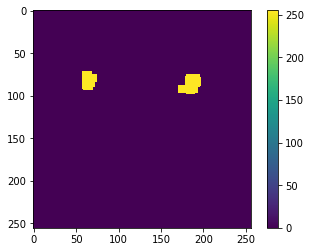

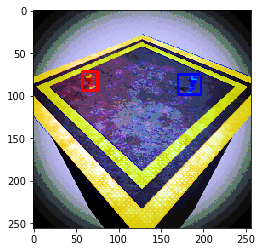

---


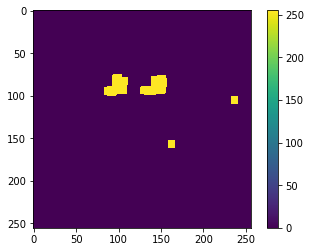

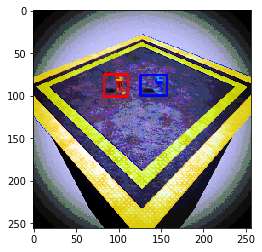

---


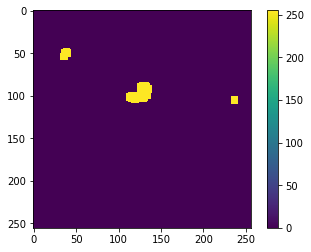

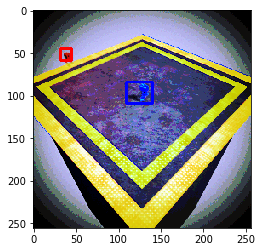

---


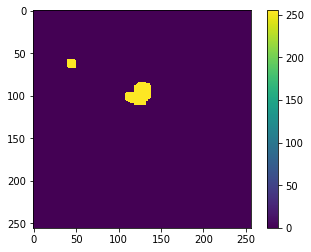

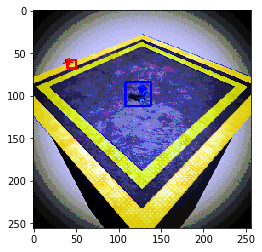

---


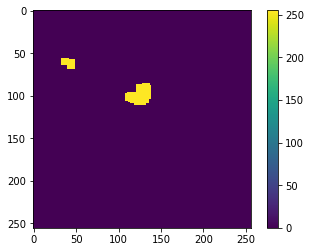

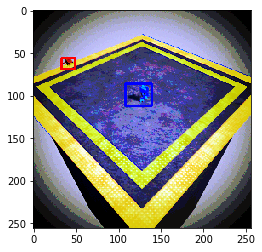

---


In [15]:
for i in img_list:
    #plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)-cv2.cvtColor(base,cv2.COLOR_BGR2GRAY))
    #plt.show()
    #minus = np.abs(cv2.bilateralFilter(i[:,:,1],7, 75, 75)-cv2.bilateralFilter(base[:,:,1],7,75,75))
    minus = np.abs(i[:,:,1]-base[:,:,1])
    #minus = np.abs(i[:,:,0]-base[:,:,0])
    #minus = np.abs(i[:,:,2]-base[:,:,2])
    #plt.imshow(minus)
    
    #print(np.where((minus >= 170) & (minus <= 220)))
    
    canvas = np.zeros((256,256))
    
    canvas[np.where((minus >= 200) & (minus <= 220))] = 200
    
    
    kernel = np.ones((5,5), np.uint8)
    
    canvas = cv2.dilate(canvas, kernel, iterations = 3)
    canvas = cv2.erode(canvas, kernel, iterations = 1)
    
    canvas = cv2.threshold(canvas, 126, 255, cv2.THRESH_BINARY) 
    
    
    a, b, c = cv2.findContours(np.uint8(canvas[1]), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    
    #print(a, b)
    
    #cv2.drawContours(np.zeros((256,256)), b, -1, (0,124,0), 1)
    
    #plt.imshow(i)
    #plt.show()
    plt.imshow(a)
    plt.colorbar()
    plt.show()
    
    i2 = i.copy()
    
    cont_area = [cv2.contourArea(contour) for contour in b]
    #print(sorted(cont_area))
    biggest_2_area = sorted(cont_area)[-2:][::-1]
    #print(biggest_2_area)
    
    contour_select = {}
    
    for contour in b:
        (x,y,w,h) = cv2.boundingRect(contour)
        #plt.imshow(i[y:y+h,x:x+w][:,:,2])
        #plt.show()
        #print(np.mean(i[y:y+h,x:x+w][:,:,2]))
        #print(cv2.contourArea(contour))
        
        if cv2.contourArea(contour) in biggest_2_area:
            contour_select[cv2.contourArea(contour)] = np.mean(i[y:y+h,x:x+w][:,:,2])
    
    #print(contour_select)
    
    for contour in b:
        (x,y,w,h) = cv2.boundingRect(contour)
        
       # print('######',cv2.contourArea(contour), contour_select[cv2.contourArea(contour)])
       # print(max([contour_select[i] for i in contour_select])== contour_select[cv2.contourArea(contour)])
        
        if cv2.contourArea(contour) in contour_select:
            if max([contour_select[i] for i in contour_select]) == contour_select[cv2.contourArea(contour)]:
                #print('Max')
                cv2.rectangle(i2, (x,y), (x+w,y+h), (0, 0, 255), 2)
            else:
                #print('No max')
                cv2.rectangle(i2, (x,y), (x+w,y+h), (255, 0, 0), 2)
                
    
    plt.imshow(i2)
    plt.show()
    
    
    print('---')
    

In [118]:
pos = []
for n, contour in enumerate(b):
    print(n)
    (x,y,w,h) = cv2.boundingRect(contour)
    pos.append(((int(x+w/2), int(y+h/2))))

0


(372, 258)


/Users/Jose/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


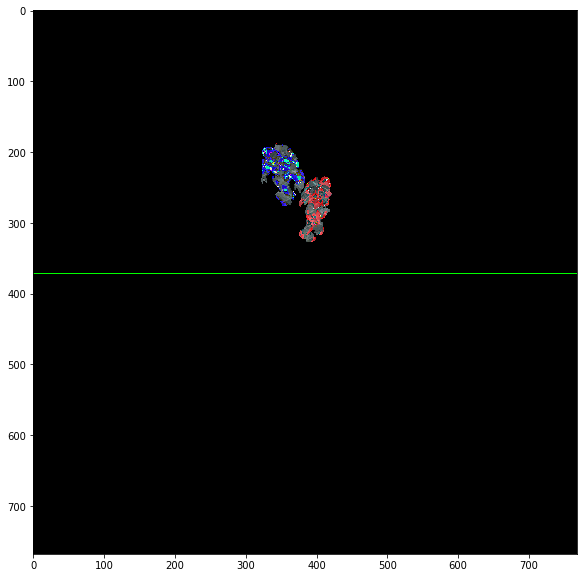

In [126]:
for p in pos:
    print(p)
    modified_imgs[-8][pos]=[0,255,0]
plt.figure(figsize=(10,10))
plt.imshow(modified_imgs[-8])

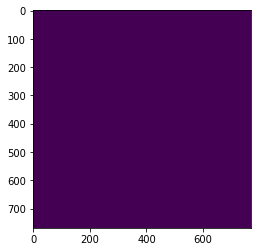

In [78]:
canvas = np.zeros((768, 768))
    
canvas[np.all(np.where((modified_imgs[0] != [0,0,0])))] = 255



plt.imshow(canvas)

In [110]:
modified_imgs[0].shape

(768, 768, 3)

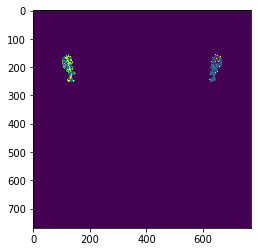

In [159]:
plt.imshow(modified_imgs[0][:,:,0])

cv2.threshold(modified_imgs[0], 126, 255, cv2.THRESH_BINARY) 

canvas = np.float32(modified_imgs[0][:,:,2])

canvas = cv2.threshold(canvas, 150, 255, cv2.THRESH_BINARY)

canvas = canvas[1]


kernel = np.ones((5,5), np.uint8)

canvas = cv2.erode(canvas, kernel, iterations = 1)
canvas = cv2.dilate(canvas, kernel, iterations = 5)


a, b, c = cv2.findContours(np.uint8(canvas), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
for i in range

In [171]:
mod.shape

(768, 768, 3)

In [169]:
mod = modified_imgs[0]
for i in b[0]:
    print(i[0])
    mod[]=(0,255,0)

151
171
172
172
173
175
176
176
179
180
200
200
201
204
205
204
204
215
216
216
236
236
226
225
225
213
212
212
192
192
191
176
175
174
174
173
159
158
151


In [157]:

x,y,w,h = cv2.boundingRect()

TypeError: Expected cv::UMat for argument 'array'

In [149]:
print(x,y,w,h)

0 0 0 0


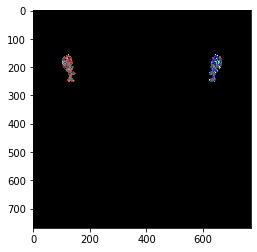

In [154]:
plt.imshow(cv2.rectangle(modified_imgs[0],(x,y), (x+w,y+h), (0,255,0),2))

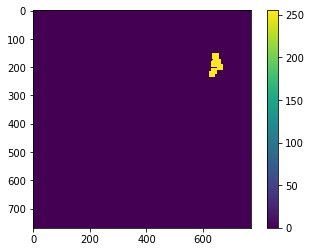

In [137]:
plt.colorbar()
plt.imshow(canvas)

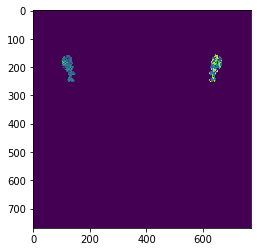

In [115]:
plt.imshow(modified_imgs[0][:,:,2])

In [107]:
cv2.threshold(modified_imgs[0][],)

TypeError: Required argument 'thresh' (pos 2) not found

In [106]:
cv2.findContours(np.uint8(modified_imgs[0]), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(3.4.6) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [98]:
_ =   cv2.findContours(modified_imgs, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

TypeError: Expected cv::UMat for argument 'image'

In [7]:
class NeurosmashAgent:
    def __init__(self):
        pass

    def step(self, info, reward, state):
        #return 0 # no action
        #return 1 # left action
        #return 2 # right action
        #return 3 # built-in random action
        return 4 # built-in ai action

In [8]:
import random
import socket
import struct

class NeurosmashEnvironment:
    def __init__(self, ip = "127.0.0.1", port = 13000):
        self.client = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.ip     = ip
        self.port   = port

        self.client.connect((ip, port))

    def init(self):
        self._send(0, 1)
        return self._receive()

    def step(self, action):
        self._send(action, 2)
        return self._receive()

    def _receive(self):
        data   = self.client.recv(1 + 1 + 256 * 256 * 3)
        info   = data[0]
        reward = data[1]
        state  = [data[i] for i in range(2, len(data))]
        return info, reward, state

    def _send(self, action, transition):
        self.client.send(bytes([action, transition]))

In [9]:
agent       = NeurosmashAgent()
environment = NeurosmashEnvironment()

In [10]:
info, reward, state = environment.init()

IndexError: index out of range

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL.ImageOps import equalize, autocontrast
from PIL import Image

In [6]:
state_list = []

In [7]:
action = agent.step(info, reward, state)
for i in range(1000):
    info, reward, state = environment.step(action)
    if len(state) == 3*256*256:
        state_list.append(state)
    if reward == 1:
        break

In [8]:
len(state_list)

5

In [9]:
import pickle

In [127]:
#pickle.dump({'state_list':state_list, 'img_list':img_list}, open( "NIPS_imgs.pickle", "wb" ) )

In [134]:
dict_vars = pickle.load(open('NIPS_imgs.pickle', 'rb'))
dict_vars.keys()
state_list = dict_vars['state_list']
img_list = dict_vars['img_list']

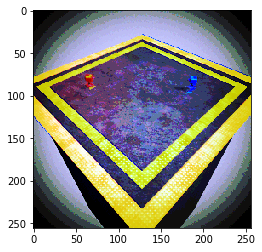

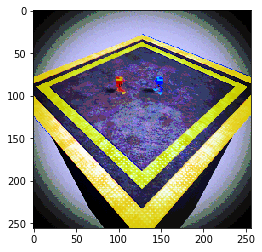

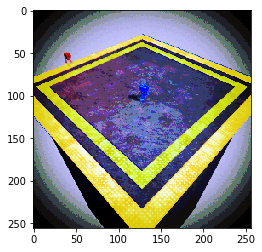

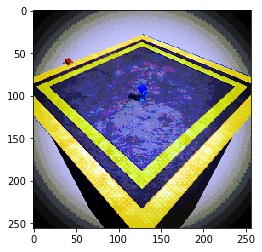

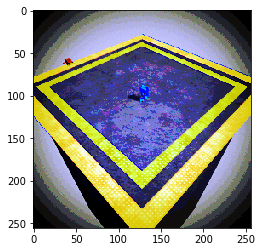

In [12]:
img_list = []
for sl in state_list:
    img = np.array(sl).reshape(3,256,256).transpose(1,2,0)[::-1]

    b, g, r = cv2.split(img)

    r = Image.fromarray(np.uint8(r))
    r = equalize(r)
    #r = autocontrast(r)
    r = np.array(r)

    g = Image.fromarray(np.uint8(g))
    g = equalize(g)
    #g = autocontrast(g)
    g = np.array(g)

    b = Image.fromarray(np.uint8(b))
    b = equalize(b)
    #b = autocontrast(b)
    b = np.array(b)

    img = cv2.merge((b,g,r))

    plt.imshow(img)
    img_list.append(img)
    plt.show()

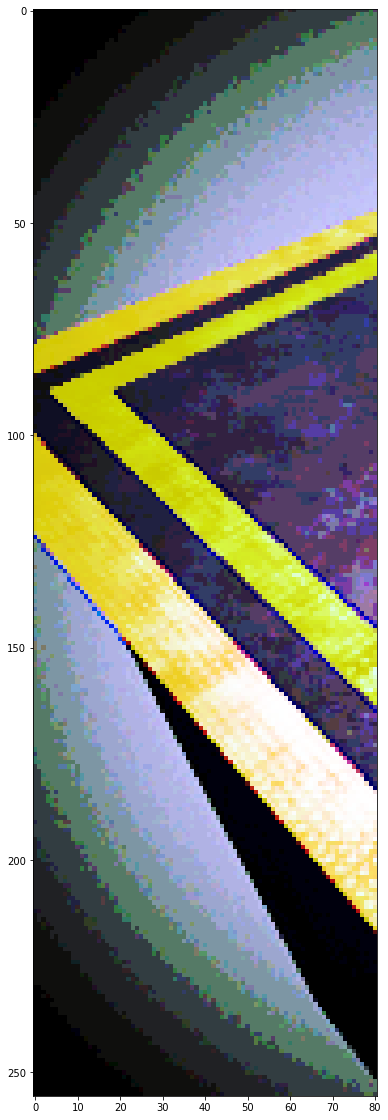

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(img_list[-2][:,:81,:])

In [6]:
plt.figure(figsize=(20,20))
base = np.hstack((img_list[-2][:,:81,:],img_list[0][:,81:160,:],img_list[2][:,160:,:]))
#cv2.imwrite('ring.png', base)

<Figure size 1440x1440 with 0 Axes>

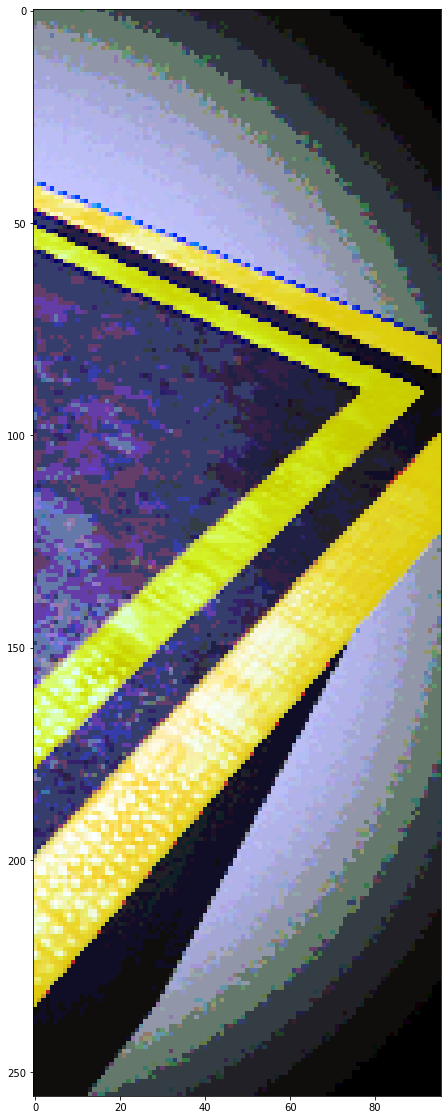

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(img_list[2][:,160:,:])

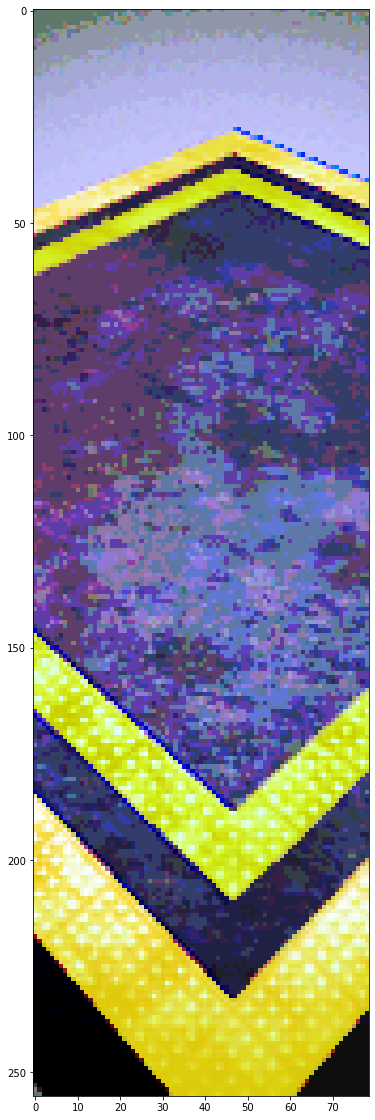

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(img_list[0][:,81:160,:])

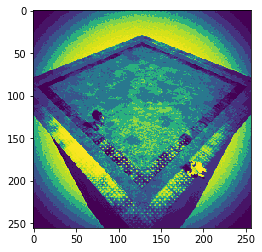

In [9]:
plt.imshow(r)

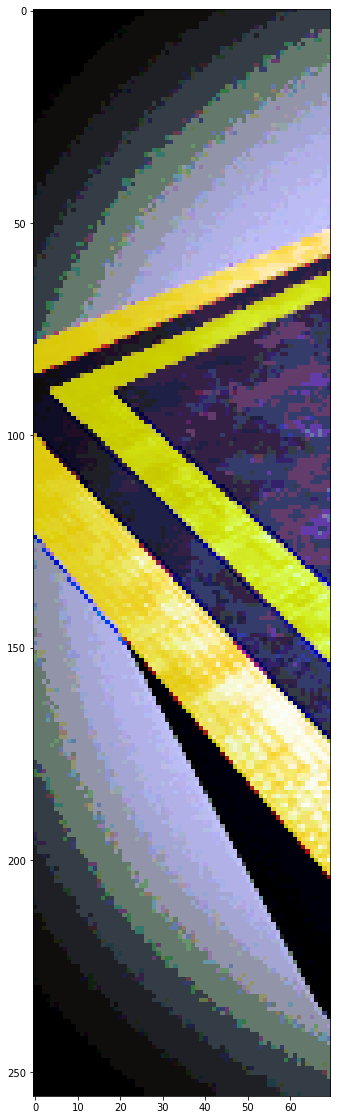

In [10]:
plt.figure(figsize = (20,20))
plt.imshow(img_list[1][:,0:70,:])

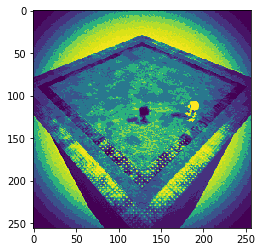

In [103]:
plt.imshow(img_list[4][:,:,2])

In [14]:
base = cv2.imread('ring.png')

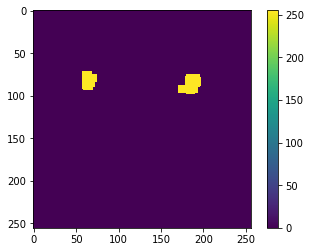

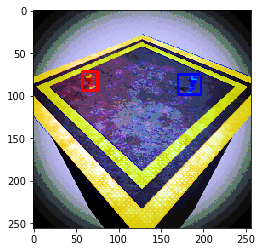

---


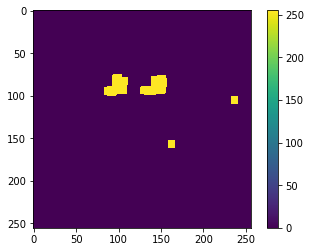

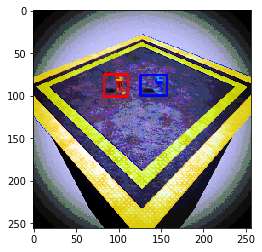

---


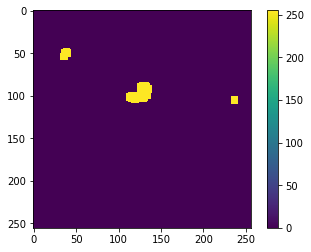

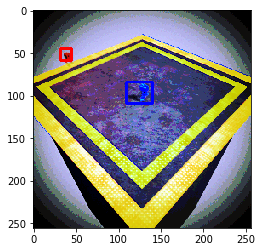

---


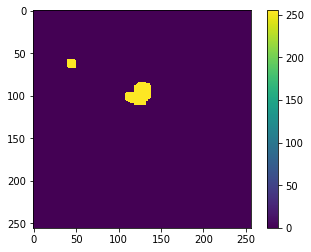

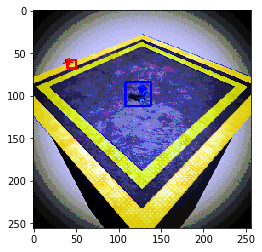

---


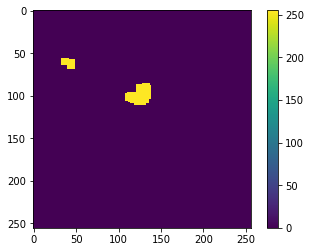

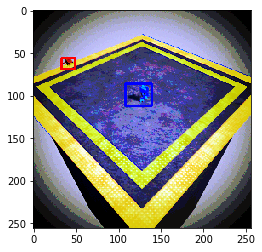

---


In [15]:
for i in img_list:
    #plt.imshow(cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)-cv2.cvtColor(base,cv2.COLOR_BGR2GRAY))
    #plt.show()
    #minus = np.abs(cv2.bilateralFilter(i[:,:,1],7, 75, 75)-cv2.bilateralFilter(base[:,:,1],7,75,75))
    minus = np.abs(i[:,:,1]-base[:,:,1])
    #minus = np.abs(i[:,:,0]-base[:,:,0])
    #minus = np.abs(i[:,:,2]-base[:,:,2])
    #plt.imshow(minus)
    
    #print(np.where((minus >= 170) & (minus <= 220)))
    
    canvas = np.zeros((256,256))
    
    canvas[np.where((minus >= 200) & (minus <= 220))] = 200
    
    
    kernel = np.ones((5,5), np.uint8)
    
    canvas = cv2.dilate(canvas, kernel, iterations = 3)
    canvas = cv2.erode(canvas, kernel, iterations = 1)
    
    canvas = cv2.threshold(canvas, 126, 255, cv2.THRESH_BINARY) 
    
    
    a, b, c = cv2.findContours(np.uint8(canvas[1]), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    
    #print(a, b)
    
    #cv2.drawContours(np.zeros((256,256)), b, -1, (0,124,0), 1)
    
    #plt.imshow(i)
    #plt.show()
    plt.imshow(a)
    plt.colorbar()
    plt.show()
    
    i2 = i.copy()
    
    cont_area = [cv2.contourArea(contour) for contour in b]
    #print(sorted(cont_area))
    biggest_2_area = sorted(cont_area)[-2:][::-1]
    #print(biggest_2_area)
    
    contour_select = {}
    
    for contour in b:
        (x,y,w,h) = cv2.boundingRect(contour)
        #plt.imshow(i[y:y+h,x:x+w][:,:,2])
        #plt.show()
        #print(np.mean(i[y:y+h,x:x+w][:,:,2]))
        #print(cv2.contourArea(contour))
        
        if cv2.contourArea(contour) in biggest_2_area:
            contour_select[cv2.contourArea(contour)] = np.mean(i[y:y+h,x:x+w][:,:,2])
    
    #print(contour_select)
    
    for contour in b:
        (x,y,w,h) = cv2.boundingRect(contour)
        
       # print('######',cv2.contourArea(contour), contour_select[cv2.contourArea(contour)])
       # print(max([contour_select[i] for i in contour_select])== contour_select[cv2.contourArea(contour)])
        
        if cv2.contourArea(contour) in contour_select:
            if max([contour_select[i] for i in contour_select]) == contour_select[cv2.contourArea(contour)]:
                #print('Max')
                cv2.rectangle(i2, (x,y), (x+w,y+h), (0, 0, 255), 2)
            else:
                #print('No max')
                cv2.rectangle(i2, (x,y), (x+w,y+h), (255, 0, 0), 2)
                
    
    plt.imshow(i2)
    plt.show()
    
    
    print('---')
    

In [32]:
data = cv2.cvtColor(img_list[4],cv2.COLOR_BGR2GRAY)-cv2.cvtColor(base,cv2.COLOR_BGR2GRAY)

#plt.imshow(img_list[4][:,:,0]-img_list[6][:,:,0])
#plt.show()
#plt.imshow(img_list[4][:,:,1]-img_list[6][:,:,1])


#kernel = np.ones((2,2),np.uint8)
#img2 = cv2.dilate(cv2.erode(img_list[1][:,:,1]-base, kernel),  kernel)
#plt.imshow(cv2.morphologyEx(img2, cv2.MORPH_OPEN, kernel))
plt.show()

#plt.imshow(img_list[4][:,:,2]-img_list[6][:,:,2])
#plt.show()

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,3) 

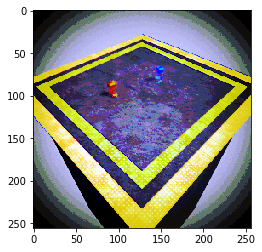

In [58]:
plt.imshow(img_list[4])

In [59]:
b, g, r = cv2.split(img_list[4])

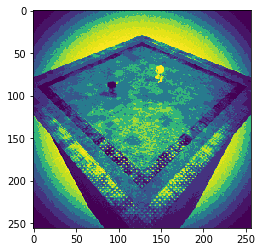

In [60]:
plt.imshow(r)

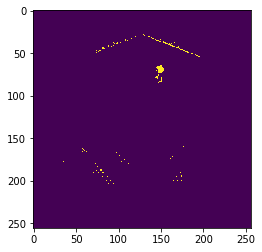

In [61]:
plt.imshow(np.where(r >= 254, 1, 0))

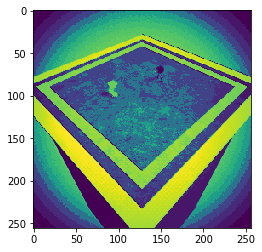

In [67]:
plt.imshow(b)

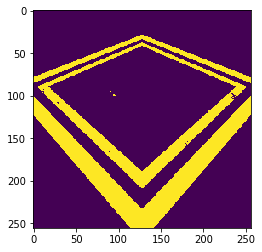

In [69]:
plt.imshow(np.where(b >= 200, 1, 0))

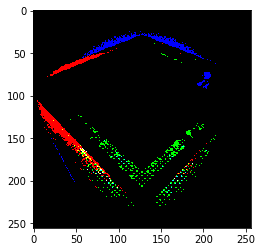

In [86]:
plt.imshow(cv2.threshold(img_list[4], 250, 255, cv2.THRESH_BINARY)[1])

In [ ]:
for e, i in enumerate(img_list):
    cv2.imwrite('agent-'+str(e)+'.png', i)

In [ ]:
for e, i in enumerate(img_list):
    cv2.imwrite('agent-'+str(e)+'.png', i)